# Uncertainty evaluation
We analyze the models' predictive uncertainty.

In [1]:
import cmcrameri.cm as cmc
from dask.diagnostics import ProgressBar
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
import numpy as np
import pandas as pd
import scipy.signal
import xarray as xr

import deeprec  # noqa
from deeprec.utils import ROOT_DIR

In [2]:
set_matplotlib_formats("retina")
plt.style.use(ROOT_DIR / "config/style_paper.mplstyle")
FIGURE_DIR = ROOT_DIR / "figures/si"

# Register dask progress bar
ProgressBar(minimum=5).register()

In [3]:
model_names = {
    "era": "DeepRec",
    "wghm-era": "DeepRec, w/ WGHM",
}


In [4]:
# Load and combine our predictions
pred_dir = ROOT_DIR / "models/predictions/ensemble-mixed"

pred_list = []
sigma_tot_list = []
sigma_ale_list = []
sigma_epi_list = []

for name, verb_name in model_names.items():
    ds = xr.open_zarr(pred_dir / f"ensemble-mixed_{name}_best-mae.zarr")
    pred_list.append(ds.twsa.rename(verb_name))
    sigma_tot_list.append(ds.sigma.rename(verb_name))
    sigma_ale_list.append(ds.sigma_ale.rename(verb_name))
    sigma_epi_list.append(ds.sigma_epi.rename(verb_name))

da_preds = xr.merge(pred_list).to_dataarray("model")
da_sigma_tot = xr.merge(sigma_tot_list).to_dataarray("model")
da_sigma_ale = xr.merge(sigma_ale_list).to_dataarray("model")
da_sigma_epi = xr.merge(sigma_epi_list).to_dataarray("model")

# Dims: (uncertainty, input, time, lat, lon)
da_sigma = xr.concat(
    [da_sigma_tot, da_sigma_ale, da_sigma_epi],
    pd.Index(["Total", "Aleatoric", "Epistemic"], name="component"),
)
da_sigma


<xarray.DataArray (component: 3, model: 2, time: 996, lat: 360, lon: 720)> Size: 6GB
dask.array<concatenate, shape=(3, 2, 996, 360, 720), dtype=float32, chunksize=(1, 1, 996, 120, 120), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float32 1kB 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
  * lon        (lon) float32 3kB -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * time       (time) datetime64[ns] 8kB 1941-01-01 1941-02-01 ... 2023-12-01
  * model      (model) object 16B 'DeepRec' 'DeepRec, w/ WGHM'
  * component  (component) object 24B 'Total' 'Aleatoric' 'Epistemic'

## Mean over time

In [5]:
# Drop time steps where one model is not available (WGHM-model ends in 2022)
da_isna = da_sigma.isnull().all(dim=["lat", "lon"]).any(dim="model").compute()
da_sigma_notna = da_sigma.where(~da_isna, drop=True)

times = da_sigma_notna.get_index("time")
print(f"Period: {times[0]} to {times[-1]}")


Period: 1941-01-01 00:00:00 to 2022-12-01 00:00:00


In [6]:
da_sigma_timemean = da_sigma_notna.mean("time")


In [7]:
plot_kwargs = dict(
    coastlines=True,
    gridlines=True,
    rasterized=True,
    coastlines_kwargs=dict(rasterized=True, linewidth=0.5),
    cbar_kwargs=dict(location="bottom", aspect=50, shrink=0.8, pad=0.06),
)

/Users/lgentn/Repositories/deeprec/.venv/lib/python3.13/site-packages/xarray/plot/facetgrid.py:685: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout()


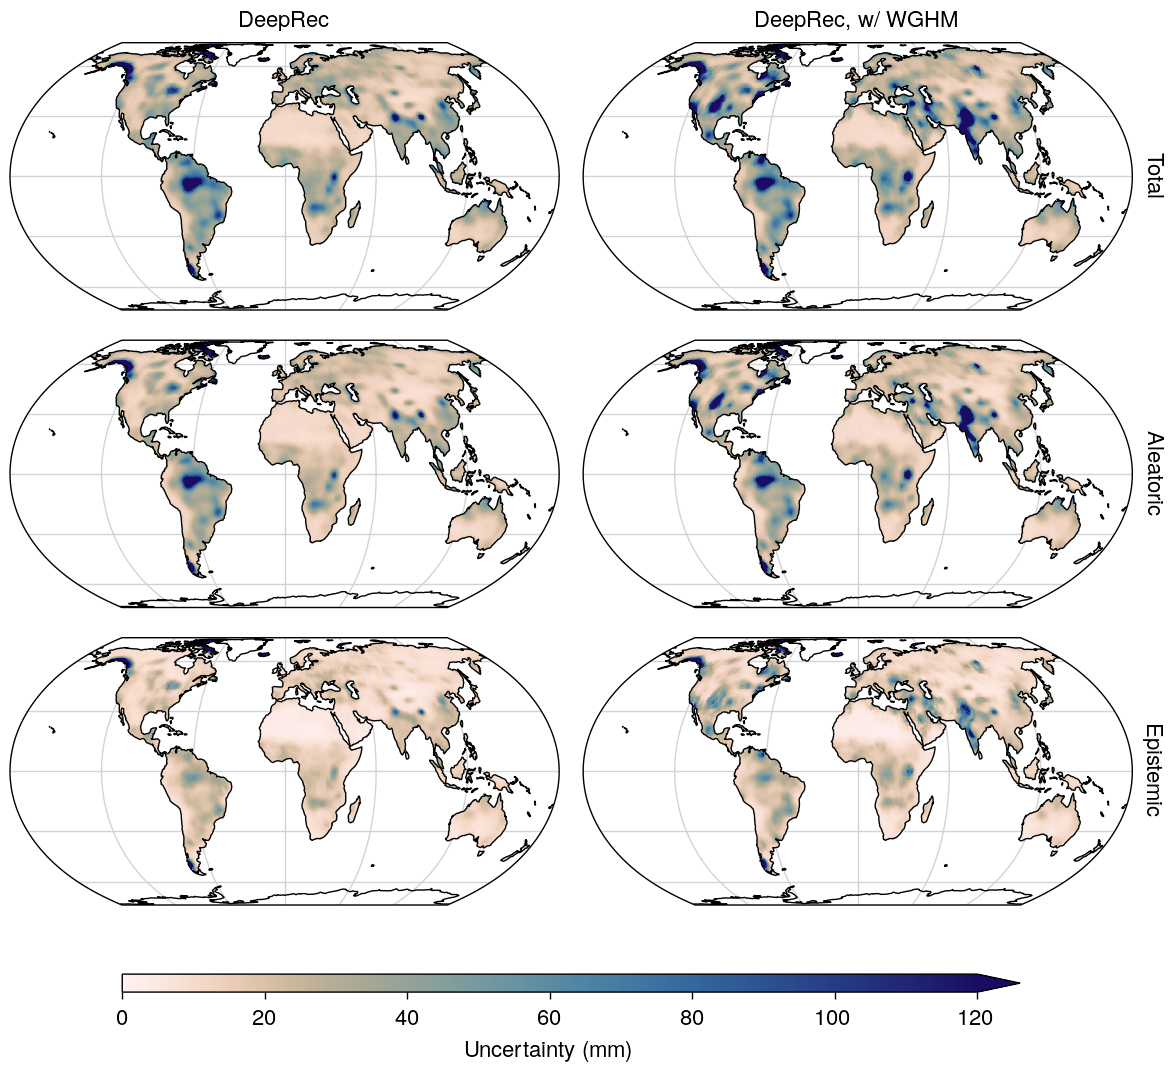

In [8]:
plot_kwargs["cbar_kwargs"]["label"] = "Uncertainty (mm)"

p = da_sigma_timemean.dr.projplot(
    col="model",
    row="component",
    vmin=0,
    vmax=120,
    cmap=cmc.lapaz_r,
    figsize=(6, 6),
    **plot_kwargs,
)
p.set_titles("{value}")

p.fig.savefig(FIGURE_DIR / "uncertainty_timeavg.pdf", backend="pgf")

## Aleatoric/Epistemic Ratio

Uncertainty ratio:

$$ \frac{\sigma^2_\text{ale}}{\sigma^2_\text{epi}} $$

In [9]:
da_vari = da_sigma_notna**2
vari_ratio = da_vari.sel(component="Aleatoric") / da_vari.sel(component="Epistemic")

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/var/folders/p2/9yn4fz8d3c12132tg5cwyrvh0000gp/T/ipykernel_49888/1273024517.py:2: SyntaxWarning: invalid escape sequence '\s'
  "Uncertainty Ratio $ \sigma^2_{ale} / \sigma^2_{epi}$"
/Users/lgentn/Repositories/deeprec/.venv/lib/python3.13/site-packages/xarray/plot/facetgrid.py:685: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout()


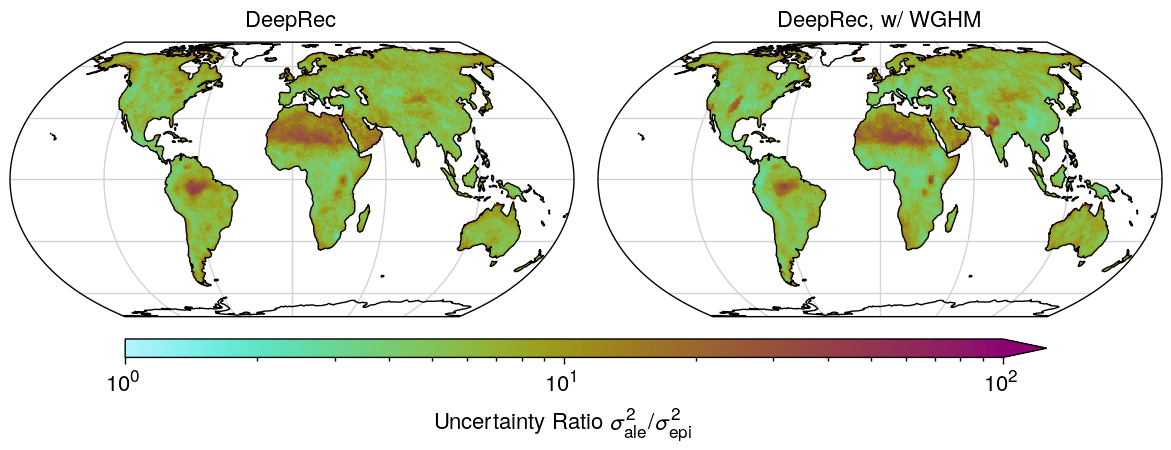

In [10]:
plot_kwargs["cbar_kwargs"]["label"] = (
    "Uncertainty Ratio $ \sigma^2_{ale} / \sigma^2_{epi}$"
)

p = vari_ratio.mean("time").dr.projplot(
    col="model",
    vmin=1,
    vmax=100,
    norm=colors.LogNorm(),
    cmap=cmc.hawaii_r,
    figsize=(6.0, 2.1),
    **plot_kwargs,
)
p.set_titles("{value}")

p.fig.savefig(FIGURE_DIR / "uncertainty_ratio.pdf", backend="pgf")


## Time series

/Users/lgentn/Repositories/deeprec/.venv/lib/python3.13/site-packages/xarray/plot/facetgrid.py:685: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout()


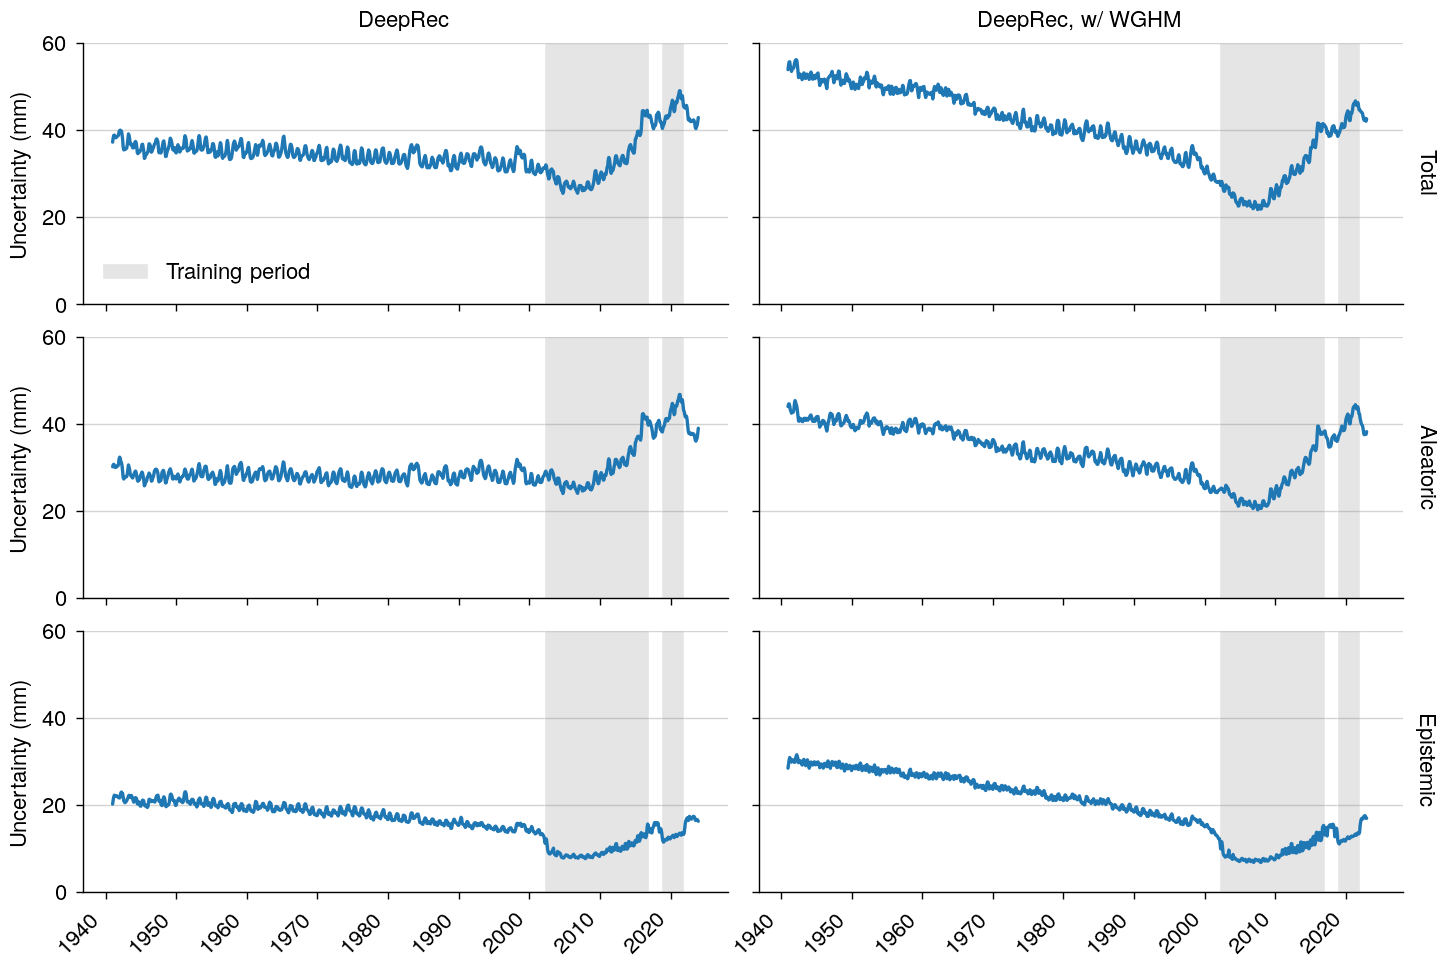

In [11]:
p = (
    da_sigma.dr.weight_lat()
    .mean(["lat", "lon"])
    .plot(col="model", row="component", figsize=(7.2, 5.0))
)
for ax in p.axs.flat:
    ax.set(ylim=(0, 60), xlabel=None)
for ax in p.axs[:, 0]:
    ax.set(ylabel="Uncertainty (mm)")

for i, ax in enumerate(p.axs.flat):
    ax.yaxis.grid()
    # Add training time
    label = "Training period" if i == 0 else None
    ax.axvspan(
        pd.Timestamp("2002-03-01"),
        pd.Timestamp("2017-01-01"),
        facecolor="tab:gray",
        alpha=0.2,
        label=label,
    )
    ax.axvspan(
        pd.Timestamp("2018-11-01"),
        pd.Timestamp("2021-12-01"),
        facecolor="tab:gray",
        alpha=0.2,
    )
    if i == 0:
        ax.legend(loc="lower left")

    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha("right")
p.set_titles(template="{value}")

p.fig.savefig(FIGURE_DIR / "uncertainty_globalavg.pdf", backend="pgf")

## Extreme event intensity vs. aleatoric uncertainty

In [12]:
# Open Rodell et al. (2023) TWS intensity time series data
rodell_df = pd.read_excel(
    ROOT_DIR / "data/raw/inputs/intensity/rodell/Figure2_data.xlsx",
    sheet_name="Total_Intensity&GISTemp",
    usecols=[0, 1, 2],
).replace(-9999.0, np.nan)
rodell_df = rodell_df.rename(
    columns=dict(zip(rodell_df.columns, ["date", "intensity", "gis_temp"]))
).set_index("date")
rodell_df

ints_tseries = xr.DataArray.from_series(rodell_df.intensity).rename(date="time") / 1e3


In [13]:
ale_tseries = (
    da_sigma.dr.weight_lat()
    .mean(["lat", "lon"])
    .sel(component="Aleatoric", drop=True)
    .rename("ours_aleatoric")
)
ale_tseries

<xarray.DataArray 'ours_aleatoric' (model: 2, time: 996)> Size: 8kB
dask.array<getitem, shape=(2, 996), dtype=float32, chunksize=(1, 996), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 8kB 1941-01-01 1941-02-01 ... 2023-12-01
  * model    (model) object 16B 'DeepRec' 'DeepRec, w/ WGHM'

In [14]:
# Merge and only keep shared time stamps
tseries = xr.merge([ale_tseries, ints_tseries], join="inner")
# Remove NaNs (only present in the beginning of extreme event intensity)
tseries = tseries.sel(time=slice("2002-08-01", None))
# Calculate first differences
tseries_diff = tseries.diff("time")
tseries_diff

<xarray.Dataset> Size: 6kB
Dimensions:         (time: 232, model: 2)
Coordinates:
  * time            (time) datetime64[ns] 2kB 2002-09-01 ... 2021-12-01
  * model           (model) object 16B 'DeepRec' 'DeepRec, w/ WGHM'
Data variables:
    ours_aleatoric  (model, time) float32 2kB dask.array<chunksize=(1, 232), meta=np.ndarray>
    intensity       (time) float64 2kB 0.9459 0.349 0.2419 ... -0.4813 -0.5452

In [16]:
ints_tseries

<xarray.DataArray 'intensity' (time: 240)> Size: 2kB
array([      nan,       nan,       nan,       nan,       nan,       nan,
             nan, 0.7187958, 1.664716 , 2.013704 , 2.255581 , 2.682269 ,
       2.476875 , 2.164132 , 2.501871 , 2.411997 , 2.134053 , 1.934224 ,
       1.627798 , 1.326406 , 1.152443 , 1.119769 , 1.211926 , 1.327614 ,
       1.186188 , 1.317892 , 2.020474 , 1.864252 , 1.43113  , 1.358599 ,
       1.257232 , 1.069449 , 1.229256 , 1.376182 , 1.33188  , 1.353114 ,
       1.492753 , 1.750851 , 2.288284 , 2.152756 , 2.122712 , 2.114228 ,
       1.79733  , 1.783482 , 1.444328 , 1.279934 , 1.352644 , 1.473416 ,
       1.457929 , 1.440268 , 1.354128 , 1.147111 , 1.476719 , 1.496283 ,
       1.499401 , 1.407477 , 1.102138 , 1.207453 , 1.108127 , 1.043328 ,
       1.209618 , 1.433971 , 1.422814 , 1.021151 , 0.978847 , 0.8710272,
       0.8011228, 0.7824708, 0.6365472, 0.5250556, 0.5366467, 0.5468734,
       0.707137 , 0.8672208, 1.022187 , 0.829579 , 0.9679175, 0.7172657,
       0.7535615, 0.8017954, 0.5928079, 0.4523816, 0.3237727, 0.4541545,
       0.7889265, 0.8731609, 0.9609138, 1.130903 , 1.583286 , 1.690008 ,
       1.46992  , 1.20108  , 1.226611 , 1.070925 , 1.252863 , 1.480673 ,
       1.425571 , 1.159551 , 1.18813  , 1.16044  , 1.089418 , 0.842298 ,
       0.7918022, 1.202493 , 1.371604 , 1.263372 , 1.013164 , 1.584701 ,
       1.872304 , 1.665108 , 2.355841 , 2.609901 , 2.648961 , 2.206578 ,
       2.082045 , 2.133862 , 1.714054 , 1.625856 , 1.720493 , 2.021212 ,
       2.285429 , 2.26588  , 2.302622 , 2.415068 , 1.436992 , 1.826317 ,
       1.864101 , 1.751311 , 1.339786 , 1.2466   , 1.042708 , 1.261461 ,
       1.184011 , 1.017161 , 1.072446 , 0.7221219, 0.6983414, 0.5836914,
       0.3966538, 1.198941 , 1.209949 , 0.5248951, 0.5282241, 0.6727203,
       0.7049806, 0.652861 , 1.282029 , 1.304738 , 1.392818 , 1.19407  ,
       0.7976266, 0.7689843, 0.898926 , 0.6882205, 0.6964387, 0.6135936,
       0.8284921, 0.9408823, 1.152495 , 1.353165 , 1.445162 , 0.9437988,
       1.091732 , 1.135776 , 1.389609 , 2.069469 , 2.325472 , 2.440713 ,
       2.540638 , 2.634848 , 2.61137  , 2.04508  , 2.628948 , 2.259925 ,
       1.862465 , 1.550414 , 1.220102 , 1.361175 , 1.102153 , 1.15465  ,
       1.547987 , 1.706578 , 1.862019 , 2.131995 , 1.916043 , 1.617749 ,
       1.040281 , 0.861791 , 0.7604893, 0.7093673, 0.7734175, 0.9256332,
       1.05441  , 1.397898 , 1.463687 , 1.492357 , 1.220739 , 1.153605 ,
       0.9401812, 1.052423 , 1.549946 , 1.853317 , 2.300489 , 2.480103 ,
       2.638592 , 2.872119 , 3.030909 , 2.995458 , 2.88246  , 2.703262 ,
       2.615842 , 2.5215   , 2.825392 , 3.337694 , 3.176273 , 3.481244 ,
       3.50084  , 3.785208 , 3.743491 , 3.879641 , 3.695126 , 3.099414 ,
       3.076369 , 3.38108  , 4.312521 , 3.89316  , 3.683764 , 3.568068 ,
       4.212527 , 4.538996 , 4.36269  , 4.35958  , 4.771153 , 4.443237 ,
       4.731227 , 4.745219 , 4.794877 , 4.358488 , 3.877165 , 3.331977 ])
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-01-01 2002-02-01 ... 2021-12-01

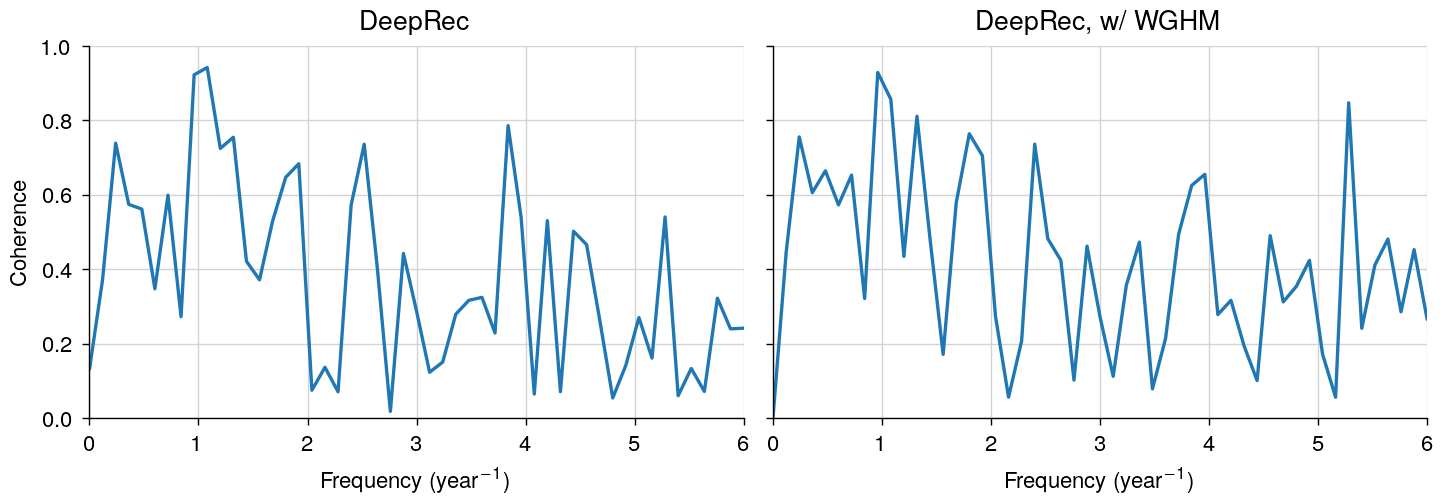

In [15]:
# Sampling freq
fs = 1
y = tseries_diff.intensity.to_numpy()

fig, axs = plt.subplots(ncols=2, figsize=(7.2, 2.5), sharex=True, sharey=True)

for ax, model_name in zip(axs, model_names.values()):
    # Get aleatoric uncertainty for DeepRec variant
    x = tseries_diff.sel(model=model_name).ours_aleatoric.to_numpy()
    # Calc coherence
    f, Cxy = scipy.signal.coherence(x, y, fs, nperseg=100)
    # Cycles/month to cycles/year
    f *= 12
    ax.plot(f, Cxy)
    ax.set(title=model_name, xlabel="Frequency (year$^{-1}$)")
    ax.xaxis.grid(True)
    ax.yaxis.grid(True, which="both")
axs[0].set(ylabel="Coherence", ylim=(0, 1), xlim=(0, 6))

fig.savefig(FIGURE_DIR / "coherence_aleatoric_extremeevents.pdf", backend="pgf")